# Quantum Channel for the Ancilla Density Matrix in Random Unitary Circuit

![](RUC.png)

We are going to evaluate the effect of the matrices along the diagonal slice on the ancilla density matrix. After summing over the indices $(s_1,s_2)$ for a neighbouring pair of sites we lose the final layer by unitarity, and we are left with:

![](MPO.png)

The input ancilla density matrix $\rho_{a_1a_2a_3,\bar a_1\bar a_2 \bar a_3}$ will be contracted in at the bottom, and the indices of the output matrix $\rho'_{b_1b_2b_3,\bar b_1\bar b_2 \bar b_3}$ will pop out of the top. The task is to evaluate $\rho'$ for a given assignment of indices $b_j$ if all components of $\rho$ are known.

The first thing to notice is that the final index is traced over, lowering the dimension of the density matrix before we start. We then work from the [middle out](https://www.youtube.com/watch?v=0rhdOt9bOHE), contracting in a $U$ and $\bar U$ at each step. This is an $O(N^2)$ operation, where $N=q^d$ for depth $d$.

In [1]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

In [2]:
from ruc_einsum import (cptp_map, apply_gates, tensor_trace, trace_square, matrix_to_tensor, 
                        tensor_to_matrix, random_ρ, random_gates, random_state, inner_product)

## Complexity

In [3]:
timeit_results = []
q = 2
depths =  np.arange(5,13)
for d in depths:
    res = %timeit -o cptp_map(random_ρ(q, d), random_gates(q, d))
    timeit_results.append(res.average)

1.76 ms ± 26.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
5.54 ms ± 369 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25.2 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
83 ms ± 9.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
345 ms ± 48.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.41 s ± 6.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.3 s ± 27.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


KeyboardInterrupt: 

Check the $4^d$ scaling

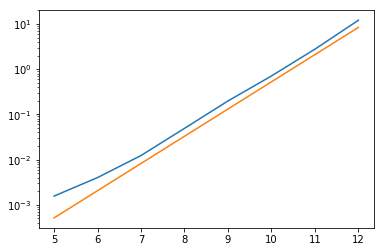

In [56]:
plt.semilogy(depths, timeit_results, depths, 0.0000005*4**depths)

## Purity from CPTP map

In [3]:
q = 2
depth = 10
# ρ = np.zeros(2*depth*[q])
# ρ[tuple(2*depth*[0])] = 1
ρ = random_ρ(q, depth)
purity_trace = np.array([])

for step in range(1000):
    purity_trace = np.append(purity_trace, trace_square(ρ))
    ρ = cptp_map(ρ, random_gates(q, depth))
    if step % 100 == 0:
        print("step ", step)

step  0
step  100
step  200
step  300


KeyboardInterrupt: 

In [4]:
np.mean(purity_trace)

(0.11024592063048033+1.3056041938408464e-18j)

In [5]:
-np.log(np.mean(purity_trace))

(2.2050417664238173-1.1842653101124165e-17j)

In [8]:
-np.log((4/5)**10)

2.231435513142097

/Users/austen/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


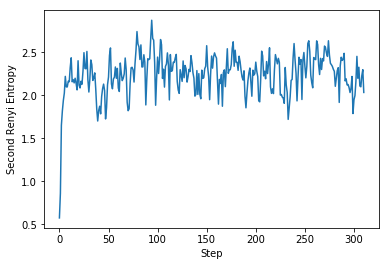

In [9]:
plt.plot(-np.log(purity_trace))
plt.xlabel("Step")
plt.ylabel("Second Renyi Entropy");

/Users/austen/anaconda/lib/python3.6/site-packages/numpy/lib/histograms.py:761: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/austen/anaconda/lib/python3.6/site-packages/matplotlib/transforms.py:827: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/Users/austen/anaconda/lib/python3.6/site-packages/matplotlib/transforms.py:2010: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


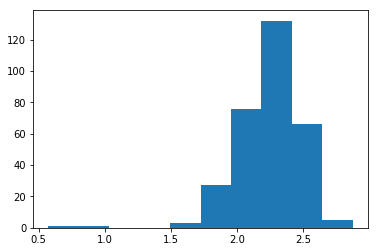

In [10]:
plt.hist(-np.log(purity_trace), bins=10);

Looks completely symmetric! 

## Purity from Trajectories

Now we try it the second way using the relationship

$$
\gamma = \mathrm tr\left[\rho_A^2\right] = \mathbb{E}_{x_1:x_N,\atop y_1:y_N}|\langle\psi_{x_1:x_N}|\psi_{y_1:y_N}\rangle|^2
$$

where $|\psi_{x_1:x_N}\rangle$ represents a normalized ancilla state arising from the trajectory $x_1:x_N$, where each step of the trajetory consists of a pair $x_j=(x^{(1)}_j, x^{(2)}_{j})$, where $x^{(1,2)}_j\in 1,\ldots q$.

__Note__ that this way requires one extra unitary as we don't do the sum over $x_j$.

In [25]:
q = 2
depth = 10
state1 = random_state(q, depth)
state2 = state1
purity_trace = np.array([])

for step in range(10000):
    purity_trace = np.append(purity_trace, np.abs(inner_product(state1, state2))**2)
    gates = random_gates(q, depth + 1) # Need one more gate than in the CPTP case
    state1 = apply_gates(state1, gates)
    state2 = apply_gates(state2, gates)
    if step % 1000 == 0:
        print("step ", step)

step  0
step  1000
step  2000
step  3000
step  4000
step  5000
step  6000
step  7000
step  8000
step  9000


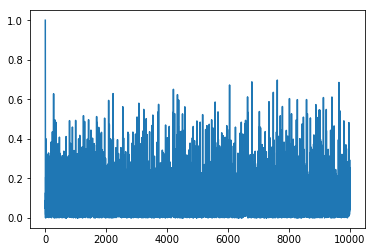

In [26]:
plt.plot(purity_trace)

In [27]:
np.mean(purity_trace)

0.09547265417004835

In [28]:
(4/5)**10

0.10737418240000006

## Spectrum

In [17]:
q = 2
depth = 10
# ρ = np.zeros(2*depth*[q])
# ρ[tuple(2*depth*[0])] = 1
ρ = random_ρ(q, depth)
eigenvalues = np.array([])

for step in range(1000):
    eigenvalues = np.concatenate([eigenvalues, eigh(tensor_to_matrix(ρ), eigvals_only=True)])
    ρ = cptp_map(ρ, random_gates(q, depth))
    if step % 100 == 0:
        print("step ", step)

step  0
step  100


KeyboardInterrupt: 

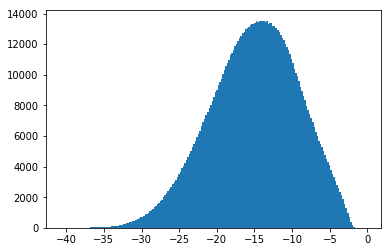

In [67]:
plt.hist(np.log(eigenvalues), bins=200);

Compare with fully random density matrix

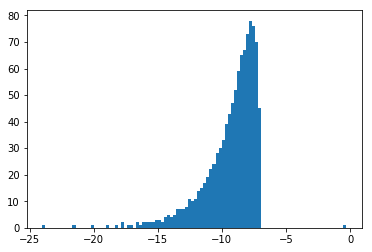

In [37]:
plt.hist(np.log(eigh(tensor_to_matrix(random_ρ(2, 10)), eigvals_only=True)), bins=100);